**Atef Amor Ids4**

In [ ]:
!pip install tensorflow

In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import skew, chi2, chi2_contingency
import matplotlib.ticker as ticker


from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

import keras
import keras_tuner

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout,LeakyReLU, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.regularizers import l1,l2
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,silhouette_score,confusion_matrix,classification_report,roc_auc_score,roc_curve

import os
import pickle

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
pd.set_option("display.max.columns", None)
pd.set_option("display.max.rows", None)

# loading and merging data

In [ ]:
LIST_EVENTS = pd.read_csv('UNSW-NB15_LIST_EVENTS.csv')
NB15_1 = pd.read_csv('UNSW-NB15_1.csv')
NB15_2 = pd.read_csv('UNSW-NB15_2.csv')
NB15_3 = pd.read_csv('UNSW-NB15_3.csv')
NB15_4 = pd.read_csv('UNSW-NB15_4.csv')
NB15_features = pd.read_csv('NUSW-NB15_features.csv', encoding='cp1252')

In [ ]:
LIST_EVENTS

,Attack category,Attack subcategory,Number of events
0,normal,NaN,2218761
1,Fuzzers,FTP,558
2,Fuzzers,HTTP,1497
3,Fuzzers,RIP,3550
4,Fuzzers,SMB,5245
5,Fuzzers,Syslog,1851
6,Fuzzers,PPTP,1583
7,Fuzzers,FTP,248
8,Fuzzers,DCERPC,164
9,Fuzzers,OSPF,993


In [ ]:
NB15_features

,No.,Name,Type,Description
0,1,srcip,nominal,Source IP address
1,2,sport,integer,Source port number
2,3,dstip,nominal,Destination IP address
3,4,dsport,integer,Destination port number
4,5,proto,nominal,Transaction protocol
5,6,state,nominal,Indicates to the state and its dependent proto...
6,7,dur,Float,Record total duration
7,8,sbytes,Integer,Source to destination transaction bytes
8,9,dbytes,Integer,Destination to source transaction bytes
9,10,sttl,Integer,Source to destination time to live value


In [ ]:
NB15_1.head()

,59.166.0.0,1390,149.171.126.6,53,udp,CON,0.001055,132,164,31,29,0,0.1,dns,500473.9375,621800.9375,2,2.1,0.2,0.3,0.4,0.5,66,82,0.6,0.7,0.8,0.9,1421927414,1421927414.1,0.017,0.013,0.10,0.11,0.12,0.13,0.14,0.15,0.16,0.17,3,7,1,3.1,1.1,1.2,1.3,Unnamed: 47,0.18
0,59.166.0.0,33661,149.171.126.9,1024,udp,CON,0.036133,528,304,31,29,0,0,-,87676.08594,50480.17188,4,4,0,0,0,0,132,76,0,0,9.891010,10.682733,1421927414,1421927414,7.005,7.564333,0.0,0.0,0.0,0,0,0,0,0,2,4,2,3,1,1,2,NaN,0
1,59.166.0.6,1464,149.171.126.7,53,udp,CON,0.001119,146,178,31,29,0,0,dns,521894.53130,636282.37500,2,2,0,0,0,0,73,89,0,0,0.000000,0.000000,1421927414,1421927414,0.017,0.013000,0.0,0.0,0.0,0,0,0,0,0,12,8,1,2,2,1,1,NaN,0
2,59.166.0.5,3593,149.171.126.5,53,udp,CON,0.001209,132,164,31,29,0,0,dns,436724.56250,542597.18750,2,2,0,0,0,0,66,82,0,0,0.000000,0.000000,1421927414,1421927414,0.043,0.014000,0.0,0.0,0.0,0,0,0,0,0,6,9,1,1,1,1,1,NaN,0
3,59.166.0.3,49664,149.171.126.0,53,udp,CON,0.001169,146,178,31,29,0,0,dns,499572.25000,609067.56250,2,2,0,0,0,0,73,89,0,0,0.000000,0.000000,1421927414,1421927414,0.005,0.003000,0.0,0.0,0.0,0,0,0,0,0,7,9,1,1,1,1,1,NaN,0
4,59.166.0.0,32119,149.171.126.9,111,udp,CON,0.078339,568,312,31,29,0,0,-,43503.23438,23896.14258,4,4,0,0,0,0,142,78,0,0,29.682221,34.370340,1421927414,1421927414,21.003,24.315000,0.0,0.0,0.0,0,0,0,0,0,2,4,2,3,1,1,2,NaN,0


In [ ]:
NB15_2.head()

,59.166.0.0,6055,149.171.126.5,54145,tcp,FIN,0.072974,4238,60788,31,29,7,30,-,458245.4375,6571546.5,72,72.1,255,255.1,1003293149,1003585034,59,844,0,0.1,62.04531,61.899776,1421955842,1421955842.1,1.02269,0.997042,0.002317,0.002173,0.000144,0.2,0.3,0.4,0.5,0.6,13,13.1,6,7.1,1,1.1,2,Unnamed: 47,0.7
0,59.166.0.0,7832,149.171.126.3,5607,tcp,FIN,0.144951,5174,91072,31,29,7,39,-,2.824127e+05,4.971776e+06,90,92,255,255,3152877672,1047439924,57,990,0,0,98.166675,97.062913,1421955842,1421955842,1.624562,1.587374,0.000665,0.000497,0.000168,0,0,0.0,0.0,0,13,13,6,7,1,1,2,NaN,0
1,59.166.0.8,11397,149.171.126.6,21,tcp,FIN,0.116107,2934,3742,31,29,11,15,ftp,1.982998e+05,2.530769e+05,52,54,255,255,3208685093,3215278370,56,69,0,0,194.564141,4.796288,1421955842,1421955842,2.314660,2.149906,0.002342,0.002151,0.000191,0,0,0.0,1.0,1,1,2,7,5,1,1,4,NaN,0
2,59.166.0.0,3804,149.171.126.3,53,udp,CON,0.000986,146,178,31,29,0,0,-,5.922921e+05,7.221095e+05,2,2,0,0,0,0,73,89,0,0,0.000000,0.000000,1421955842,1421955842,0.011000,0.009000,0.000000,0.000000,0.000000,0,0,0.0,0.0,0,13,13,6,7,1,1,2,NaN,0
3,59.166.0.8,14339,149.171.126.6,14724,tcp,FIN,0.038480,8928,320,31,29,4,1,-,1.723701e+06,5.550936e+04,14,6,255,255,1063301791,1113098865,638,53,0,0,245.278645,11.454426,1421955842,1421955842,2.960000,6.054000,0.008268,0.008075,0.000193,0,0,0.0,0.0,0,8,20,7,5,1,1,4,NaN,0
4,59.166.0.8,39094,149.171.126.3,53,udp,CON,0.001026,130,162,31,29,0,0,-,5.068226e+05,6.315789e+05,2,2,0,0,0,0,65,81,0,0,0.000000,0.000000,1421955842,1421955842,0.010000,0.002000,0.000000,0.000000,0.000000,0,0,0.0,0.0,0,8,13,6,5,1,1,1,NaN,0


In [ ]:
NB15_3.head()

,59.166.0.1,18247,149.171.126.4,7662,tcp,FIN,0.119596,4550,68342,31,29,7,33,-,300478.2813,4514398.5,78,80,255,255.1,1818376620,1818657356,58,854,0,0.1,87.137592,85.643619,1424231129,1424231129.1,1.549156,1.50719,0.000644,0.000521,0.000123,0.2,0.3,Unnamed: 37,Unnamed: 38,,6,2,2.1,5,1,1.1,2.2,Unnamed: 47,0.4
0,59.166.0.3,54771,149.171.126.2,27709,tcp,FIN,0.650574,8928,320,31,29,4,1,ftp-data,1.019530e+05,3.283254e+03,14,6,255,255,4075447467,3777413974,638,53,0,0,4045.664812,162.187656,1424231129,1424231129,50.044153,129.990797,0.000616,0.000495,0.000121,0,0,NaN,NaN,,3,5,2,4,1,1,4,NaN,0
1,59.166.0.8,13289,149.171.126.9,5190,tcp,FIN,0.007980,2158,2464,31,29,6,6,-,2.074185e+06,2.367920e+06,24,24,255,255,1638377249,1638673555,90,103,0,0,23.013883,0.487342,1424231129,1424231129,0.347545,0.322913,0.000668,0.000544,0.000124,0,0,NaN,NaN,,3,5,1,1,1,1,3,NaN,0
2,149.171.126.18,1043,175.45.176.3,53,udp,INT,0.000005,264,0,60,0,0,0,dns,2.112000e+08,0.000000e+00,2,0,0,0,0,0,132,0,0,0,0.000000,0.000000,1424231129,1424231129,0.005000,0.000000,0.000000,0.000000,0.000000,0,0,NaN,NaN,,19,19,19,19,19,19,19,NaN,0
3,149.171.126.18,1043,175.45.176.3,53,udp,INT,0.000005,264,0,60,0,0,0,dns,2.112000e+08,0.000000e+00,2,0,0,0,0,0,132,0,0,0,0.000000,0.000000,1424231129,1424231129,0.005000,0.000000,0.000000,0.000000,0.000000,0,0,NaN,NaN,,19,19,19,19,19,19,19,NaN,0
4,59.166.0.3,10275,149.171.126.0,25,tcp,FIN,0.486578,37462,3380,31,29,18,8,smtp,6.040882e+05,5.425646e+04,52,42,255,255,1518379503,3670369209,720,80,0,0,768.061343,24.935787,1424231128,1424231129,9.533961,11.645000,0.016012,0.009132,0.006880,0,0,NaN,NaN,,3,2,3,4,2,1,2,NaN,0


In [ ]:
NB15_4.head()

,59.166.0.9,7045,149.171.126.7,25,tcp,FIN,0.201886,37552,3380,31,29,18,8,smtp,1459437.5,130766.8672,52,42,255,255.1,1422136554,3572668484,722,80,0,0.1,456.043567,15.530109,1424250009,1424250009.1,3.943843,4.912488,0.00059,0.000473,0.000117,0.2,0.3,Unnamed: 37,Unnamed: 38,,2,2.1,7,4,1,1.1,3,Unnamed: 47,0.4
0,59.166.0.9,9685,149.171.126.2,80,tcp,FIN,5.864748,19410,1087890,31,29,2,370,http,2.640454e+04,1.481983e+06,364,746,255,255,389619597,394688654,53,1458,1,0,1031.366423,690.219581,1424250003,1424250009,16.155447,7.871279,0.000771,0.000638,0.000133,0,0,1.0,NaN,,3,1,4,4,1,1,1,NaN,0
1,59.166.0.2,1421,149.171.126.4,53,udp,CON,0.001391,146,178,31,29,0,0,dns,4.198418e+05,5.118620e+05,2,2,0,0,0,0,73,89,0,0,0.000000,0.000000,1424250009,1424250009,0.009000,0.002000,0.000000,0.000000,0.000000,0,0,NaN,NaN,,3,5,2,7,1,1,4,NaN,0
2,59.166.0.2,21553,149.171.126.2,25,tcp,FIN,0.053948,37812,3380,31,29,19,8,smtp,5.503374e+06,4.893601e+05,54,42,255,255,4047523379,1903327524,700,80,0,0,65.909688,3.155258,1424250009,1424250009,1.011547,1.302561,0.000674,0.000540,0.000134,0,0,NaN,NaN,,1,1,4,7,1,1,3,NaN,0
3,59.166.0.8,45212,149.171.126.4,53,udp,CON,0.000953,146,178,31,29,0,0,dns,6.128017e+05,7.471144e+05,2,2,0,0,0,0,73,89,0,0,0.000000,0.000000,1424250009,1424250009,0.009000,0.004000,0.000000,0.000000,0.000000,0,0,NaN,NaN,,2,5,2,1,1,1,2,NaN,0
4,59.166.0.0,59922,149.171.126.8,6881,tcp,FIN,8.633186,25056,1094788,31,29,38,390,-,2.316642e+04,1.013311e+06,446,858,255,255,497111133,526810925,56,1276,0,0,7751.702640,5572.343447,1424250000,1424250009,19.443407,10.084887,0.000654,0.000516,0.000138,0,0,NaN,NaN,,9,7,2,3,2,1,6,NaN,0


In [ ]:
NB15_1.columns = NB15_features['Name']
NB15_2.columns = NB15_features['Name']
NB15_3.columns = NB15_features['Name']
NB15_4.columns = NB15_features['Name']

In [ ]:
df = pd.concat([NB15_1, NB15_2, NB15_3, NB15_4], ignore_index=True)

In [ ]:
df.head()

Name,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,service,Sload,Dload,Spkts,Dpkts,swin,dwin,stcpb,dtcpb,smeansz,dmeansz,trans_depth,res_bdy_len,Sjit,Djit,Stime,Ltime,Sintpkt,Dintpkt,tcprtt,synack,ackdat,is_sm_ips_ports,ct_state_ttl,ct_flw_http_mthd,is_ftp_login,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,Label
0,59.166.0.0,33661,149.171.126.9,1024,udp,CON,0.036133,528,304,31,29,0,0,-,87676.08594,50480.17188,4,4,0,0,0,0,132,76,0,0,9.891010,10.682733,1421927414,1421927414,7.005,7.564333,0.0,0.0,0.0,0,0,0.0,0.0,0,2,4,2,3,1,1,2,NaN,0
1,59.166.0.6,1464,149.171.126.7,53,udp,CON,0.001119,146,178,31,29,0,0,dns,521894.53130,636282.37500,2,2,0,0,0,0,73,89,0,0,0.000000,0.000000,1421927414,1421927414,0.017,0.013000,0.0,0.0,0.0,0,0,0.0,0.0,0,12,8,1,2,2,1,1,NaN,0
2,59.166.0.5,3593,149.171.126.5,53,udp,CON,0.001209,132,164,31,29,0,0,dns,436724.56250,542597.18750,2,2,0,0,0,0,66,82,0,0,0.000000,0.000000,1421927414,1421927414,0.043,0.014000,0.0,0.0,0.0,0,0,0.0,0.0,0,6,9,1,1,1,1,1,NaN,0
3,59.166.0.3,49664,149.171.126.0,53,udp,CON,0.001169,146,178,31,29,0,0,dns,499572.25000,609067.56250,2,2,0,0,0,0,73,89,0,0,0.000000,0.000000,1421927414,1421927414,0.005,0.003000,0.0,0.0,0.0,0,0,0.0,0.0,0,7,9,1,1,1,1,1,NaN,0
4,59.166.0.0,32119,149.171.126.9,111,udp,CON,0.078339,568,312,31,29,0,0,-,43503.23438,23896.14258,4,4,0,0,0,0,142,78,0,0,29.682221,34.370340,1421927414,1421927414,21.003,24.315000,0.0,0.0,0.0,0,0,0.0,0.0,0,2,4,2,3,1,1,2,NaN,0


# Data cleaning

In [ ]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
df.shape

(2540043, 49)

In [ ]:
df.head()

Name,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,service,Sload,Dload,Spkts,Dpkts,swin,dwin,stcpb,dtcpb,smeansz,dmeansz,trans_depth,res_bdy_len,Sjit,Djit,Stime,Ltime,Sintpkt,Dintpkt,tcprtt,synack,ackdat,is_sm_ips_ports,ct_state_ttl,ct_flw_http_mthd,is_ftp_login,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,Label
0,175.45.176.3,57672,149.171.126.15,3260,tcp,CON,0.285356,986,86,62,252,2,1,-,2.304490e+04,1205.511719,6,2,255,255,761934099,3893365633,164,43,0,0,3661.562382,0.000000,1424224369,1424224369,57.071200,0.002000,0.257434,0.182930,0.074504,0,3,NaN,NaN,,10,8,4,5,3,1,7,NaN,0
1,59.166.0.8,38052,149.171.126.9,6881,tcp,FIN,0.314311,1540,1644,31,29,4,4,-,3.675341e+04,39527.730470,16,18,255,255,734569334,2907227880,96,91,0,0,1385.623880,35.106383,1424252728,1424252728,20.925067,18.459766,0.000596,0.000494,0.000102,0,0,NaN,NaN,,14,6,8,12,5,1,6,NaN,0
2,59.166.0.0,42911,149.171.126.2,38558,udp,CON,0.301180,536,304,31,29,0,0,-,1.067800e+04,6056.178711,4,4,0,0,0,0,134,76,0,0,116.927883,123.543578,1421934312,1421934313,82.683000,87.363000,0.000000,0.000000,0.000000,0,0,0.0,0.0,0,9,16,7,6,1,1,3,NaN,0
3,175.45.176.1,47439,149.171.126.14,53,udp,INT,0.000009,114,0,254,0,0,0,dns,5.066666e+07,0.000000,2,0,0,0,0,0,57,0,0,0,0.000000,0.000000,1424252582,1424252582,0.009000,0.000000,0.000000,0.000000,0.000000,0,2,NaN,NaN,,33,33,17,17,17,17,33,Generic,1
4,59.166.0.5,61544,149.171.126.6,53,udp,CON,0.001079,146,178,31,29,0,0,dns,5.412419e+05,659870.250000,2,2,0,0,0,0,73,89,0,0,0.000000,0.000000,1424243836,1424243836,0.009000,0.007000,0.000000,0.000000,0.000000,0,0,NaN,NaN,,2,2,5,4,1,1,1,NaN,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2540043 entries, 0 to 2540042
Data columns (total 49 columns):
 #   Column            Dtype  
---  ------            -----  
 0   srcip             object 
 1   sport             object 
 2   dstip             object 
 3   dsport            object 
 4   proto             object 
 5   state             object 
 6   dur               float64
 7   sbytes            int64  
 8   dbytes            int64  
 9   sttl              int64  
 10  dttl              int64  
 11  sloss             int64  
 12  dloss             int64  
 13  service           object 
 14  Sload             float64
 15  Dload             float64
 16  Spkts             int64  
 17  Dpkts             int64  
 18  swin              int64  
 19  dwin              int64  
 20  stcpb             int64  
 21  dtcpb             int64  
 22  smeansz           int64  
 23  dmeansz           int64  
 24  trans_depth       int64  
 25  res_bdy_len       int64  
 26  Sjit          

In [ ]:
df.duplicated().sum()

np.int64(480626)

In [ ]:
df = df.drop_duplicates()

In [ ]:
df.shape

(2059417, 49)

In [ ]:
df.isna().sum()

,0
Name,
srcip,0
sport,0
dstip,0
dsport,0
proto,0
state,0
dur,0
sbytes,0
dbytes,0


In [ ]:
df['attack_cat'] = df.attack_cat.fillna(value='normal').apply(lambda x: x.strip().lower())

In [ ]:
df['ct_flw_http_mthd'].fillna(0, inplace=True)

In [ ]:
df['is_ftp_login'].fillna(0, inplace=True)

In [ ]:
df.isna().sum().sum()

np.int64(0)

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Name,,,,,,,,
dur,2059417.0,6.510258e-01,1.104386e+01,0.000000e+00,3.592000e-03,2.641600e-02,3.341490e-01,8.786638e+03
sbytes,2059417.0,5.098048e+03,6.213721e+04,0.000000e+00,4.240000e+02,1.684000e+03,3.728000e+03,1.435577e+07
dbytes,2059417.0,4.192614e+04,1.698574e+05,0.000000e+00,3.040000e+02,3.080000e+03,1.991800e+04,1.465753e+07
sttl,2059417.0,4.359544e+01,5.052150e+01,0.000000e+00,3.100000e+01,3.100000e+01,3.100000e+01,2.550000e+02
dttl,2059417.0,3.650117e+01,4.370308e+01,0.000000e+00,2.900000e+01,2.900000e+01,2.900000e+01,2.540000e+02
sloss,2059417.0,6.113904e+00,2.457746e+01,0.000000e+00,0.000000e+00,4.000000e+00,7.000000e+00,5.319000e+03
dloss,2059417.0,1.893133e+01,5.952635e+01,0.000000e+00,0.000000e+00,5.000000e+00,1.500000e+01,5.507000e+03
Sload,2059417.0,9.066831e+06,7.363605e+07,0.000000e+00,8.077723e+04,5.407408e+05,1.095758e+06,5.988000e+09
Dload,2059417.0,2.954290e+06,4.480340e+06,0.000000e+00,7.632187e+04,6.691802e+05,3.835414e+06,1.287619e+08


In [ ]:
df.describe(include='object').T

,count,unique,top,freq
Name,,,,
srcip,2059417,43,59.166.0.4,192686
sport,2059417,100343,0,20653
dstip,2059417,47,149.171.126.3,192515
dsport,2059417,128297,53,233820
proto,2059417,135,tcp,1448858
state,2059417,16,FIN,1433507
service,2059417,13,-,1169180
ct_ftp_cmd,2059417,13,,1014165
attack_cat,2059417,11,normal,1959771


In [ ]:
df['state'].value_counts()

,count
state,
FIN,1433507
CON,543296
INT,75340
REQ,6050
RST,525
ECO,313
CLO,160
URH,108
ACC,41


In [ ]:
df['service'].value_counts()

,count
service,
-,1169180
dns,386755
http,203531
ftp-data,124849
smtp,81132
ssh,46981
ftp,45074
pop3,1490
ssl,142


In [ ]:
df['service'] = df['service'].apply(lambda x:"None" if x=="-" else x)

In [ ]:
df['service'].value_counts()

,count
service,
None,1169180
dns,386755
http,203531
ftp-data,124849
smtp,81132
ssh,46981
ftp,45074
pop3,1490
ssl,142


In [ ]:
df['attack_cat'].value_counts()

,count
attack_cat,
normal,1959771
exploits,27600
generic,25378
fuzzers,21795
reconnaissance,13357
dos,5665
analysis,2185
backdoor,1684
shellcode,1511


In [ ]:
df['attack_cat'] = df['attack_cat'].replace('backdoors','backdoor', regex=True).apply(lambda x: x.strip().lower())

In [ ]:
df['attack_cat'].value_counts()

,count
attack_cat,
normal,1959771
exploits,27600
generic,25378
fuzzers,21795
reconnaissance,13357
dos,5665
analysis,2185
backdoor,1984
shellcode,1511


In [ ]:
df['is_ftp_login'].value_counts()

,count
is_ftp_login,
0.0,2019733
1.0,39579
4.0,89
2.0,16


**according to given NB15_features.csv this column is a binary column**

In [ ]:
df['is_ftp_login'] = (df['is_ftp_login']>0).astype('int')

In [ ]:
df['is_ftp_login'].value_counts()

,count
is_ftp_login,
0,2019733
1,39684


In [ ]:
df['ct_ftp_cmd'].value_counts()

,count
ct_ftp_cmd,
,1014165
0,995463
1,22159
1,16694
0,10018
2,247
3,206
4,161
5,105


In [ ]:
df['ct_ftp_cmd']=df['ct_ftp_cmd'].astype('object')

In [ ]:
df['ct_ftp_cmd'].unique()

array([' ', 0, 1, '1', 2, '0', '4', 5, 3, 4, 6, 8, '2'], dtype=object)

In [ ]:
df['ct_ftp_cmd'] = df['ct_ftp_cmd'].replace(' ', '0')

In [ ]:
df['ct_ftp_cmd']=df['ct_ftp_cmd'].astype('int')

In [ ]:
df['ct_ftp_cmd'].value_counts()

,count
ct_ftp_cmd,
0,2019646
1,38853
2,263
4,250
3,206
5,105
6,91
8,3


In [ ]:
df['sport'].value_counts().head(10)

,count
sport,
0,20653
1043,18503
47439,18368
47439,1552
1043,1532
0,1392
2048,362
80,351
5060,230


In [ ]:
df['sport'] = df['sport'].astype('str')

In [ ]:
df['sport'] = pd.to_numeric(df['sport'], errors='coerce').fillna(0).astype(int)

In [ ]:
df['dsport'] = df['dsport'].astype('str')

In [ ]:
df['dsport'] = pd.to_numeric(df['dsport'], errors='coerce').fillna(0).astype(int)

In [ ]:
df['sport'].value_counts().head(10)

,count
sport,
0,22053
1043,20035
47439,19920
80,378
2048,373
5060,246
53,231
6881,208
5190,170


# EDA

## target distribution

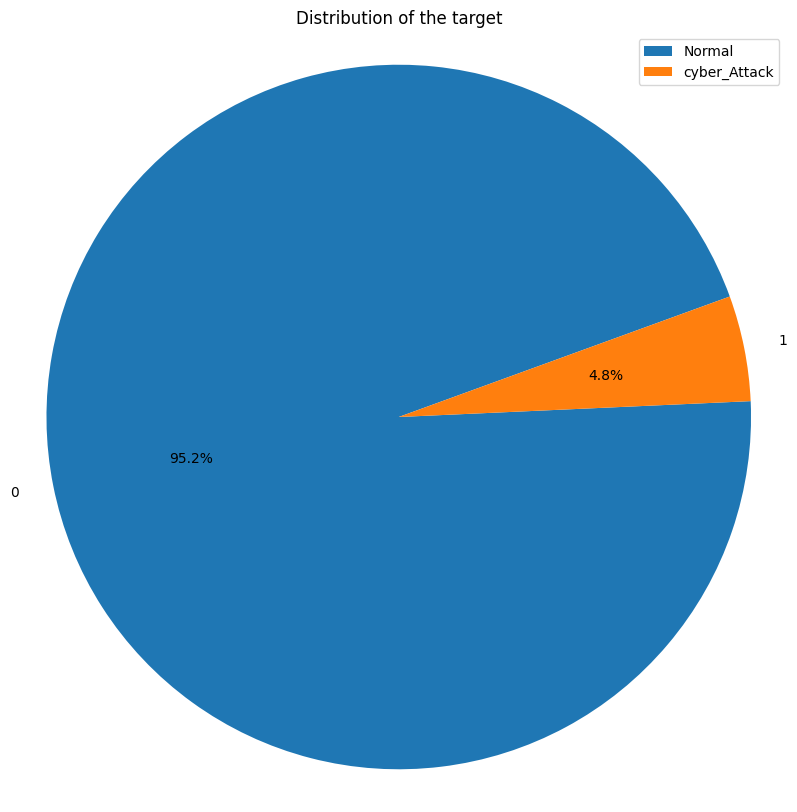

In [ ]:
plt.figure(figsize=(10, 10))
plt.pie(df['Label'].value_counts(), labels=df['Label'].value_counts().index, autopct='%1.1f%%',startangle=20)
plt.title('Distribution of the target')
plt.legend(['Normal','cyber_Attack'])
plt.axis('equal')
plt.show()

**Le nombre d'actions normales est largement supérieur à celui des cyberattaques, indiquant un déséquilibre des données.**

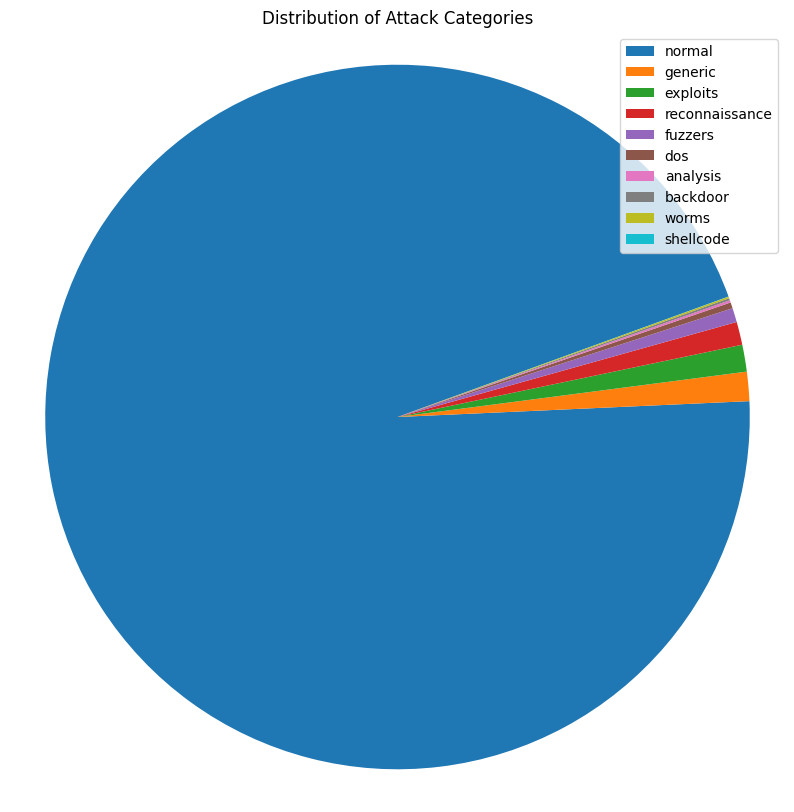

In [ ]:
plt.figure(figsize=(10, 10))
plt.pie(df['attack_cat'].value_counts(), autopct='',startangle=20)
plt.title('Distribution of Attack Categories')
plt.legend(df['attack_cat'].unique())
plt.axis('equal')
plt.show()

## correlation

In [ ]:
categ_features = df.select_dtypes(include=['object']).columns
categ_features

Index(['srcip', 'dstip', 'proto', 'state', 'service', 'attack_cat'], dtype='object', name='Name')

In [ ]:
num_features = df.select_dtypes(include=['int64', 'float64','int32']).columns
num_features

Index(['sport', 'dsport', 'dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss',
       'dloss', 'Sload', 'Dload', 'Spkts', 'Dpkts', 'swin', 'dwin', 'stcpb',
       'dtcpb', 'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len', 'Sjit',
       'Djit', 'Stime', 'Ltime', 'Sintpkt', 'Dintpkt', 'tcprtt', 'synack',
       'ackdat', 'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm',
       'ct_src_ ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'Label'],
      dtype='object', name='Name')

<Axes: title={'center': 'Correlation'}, xlabel='Name', ylabel='Name'>

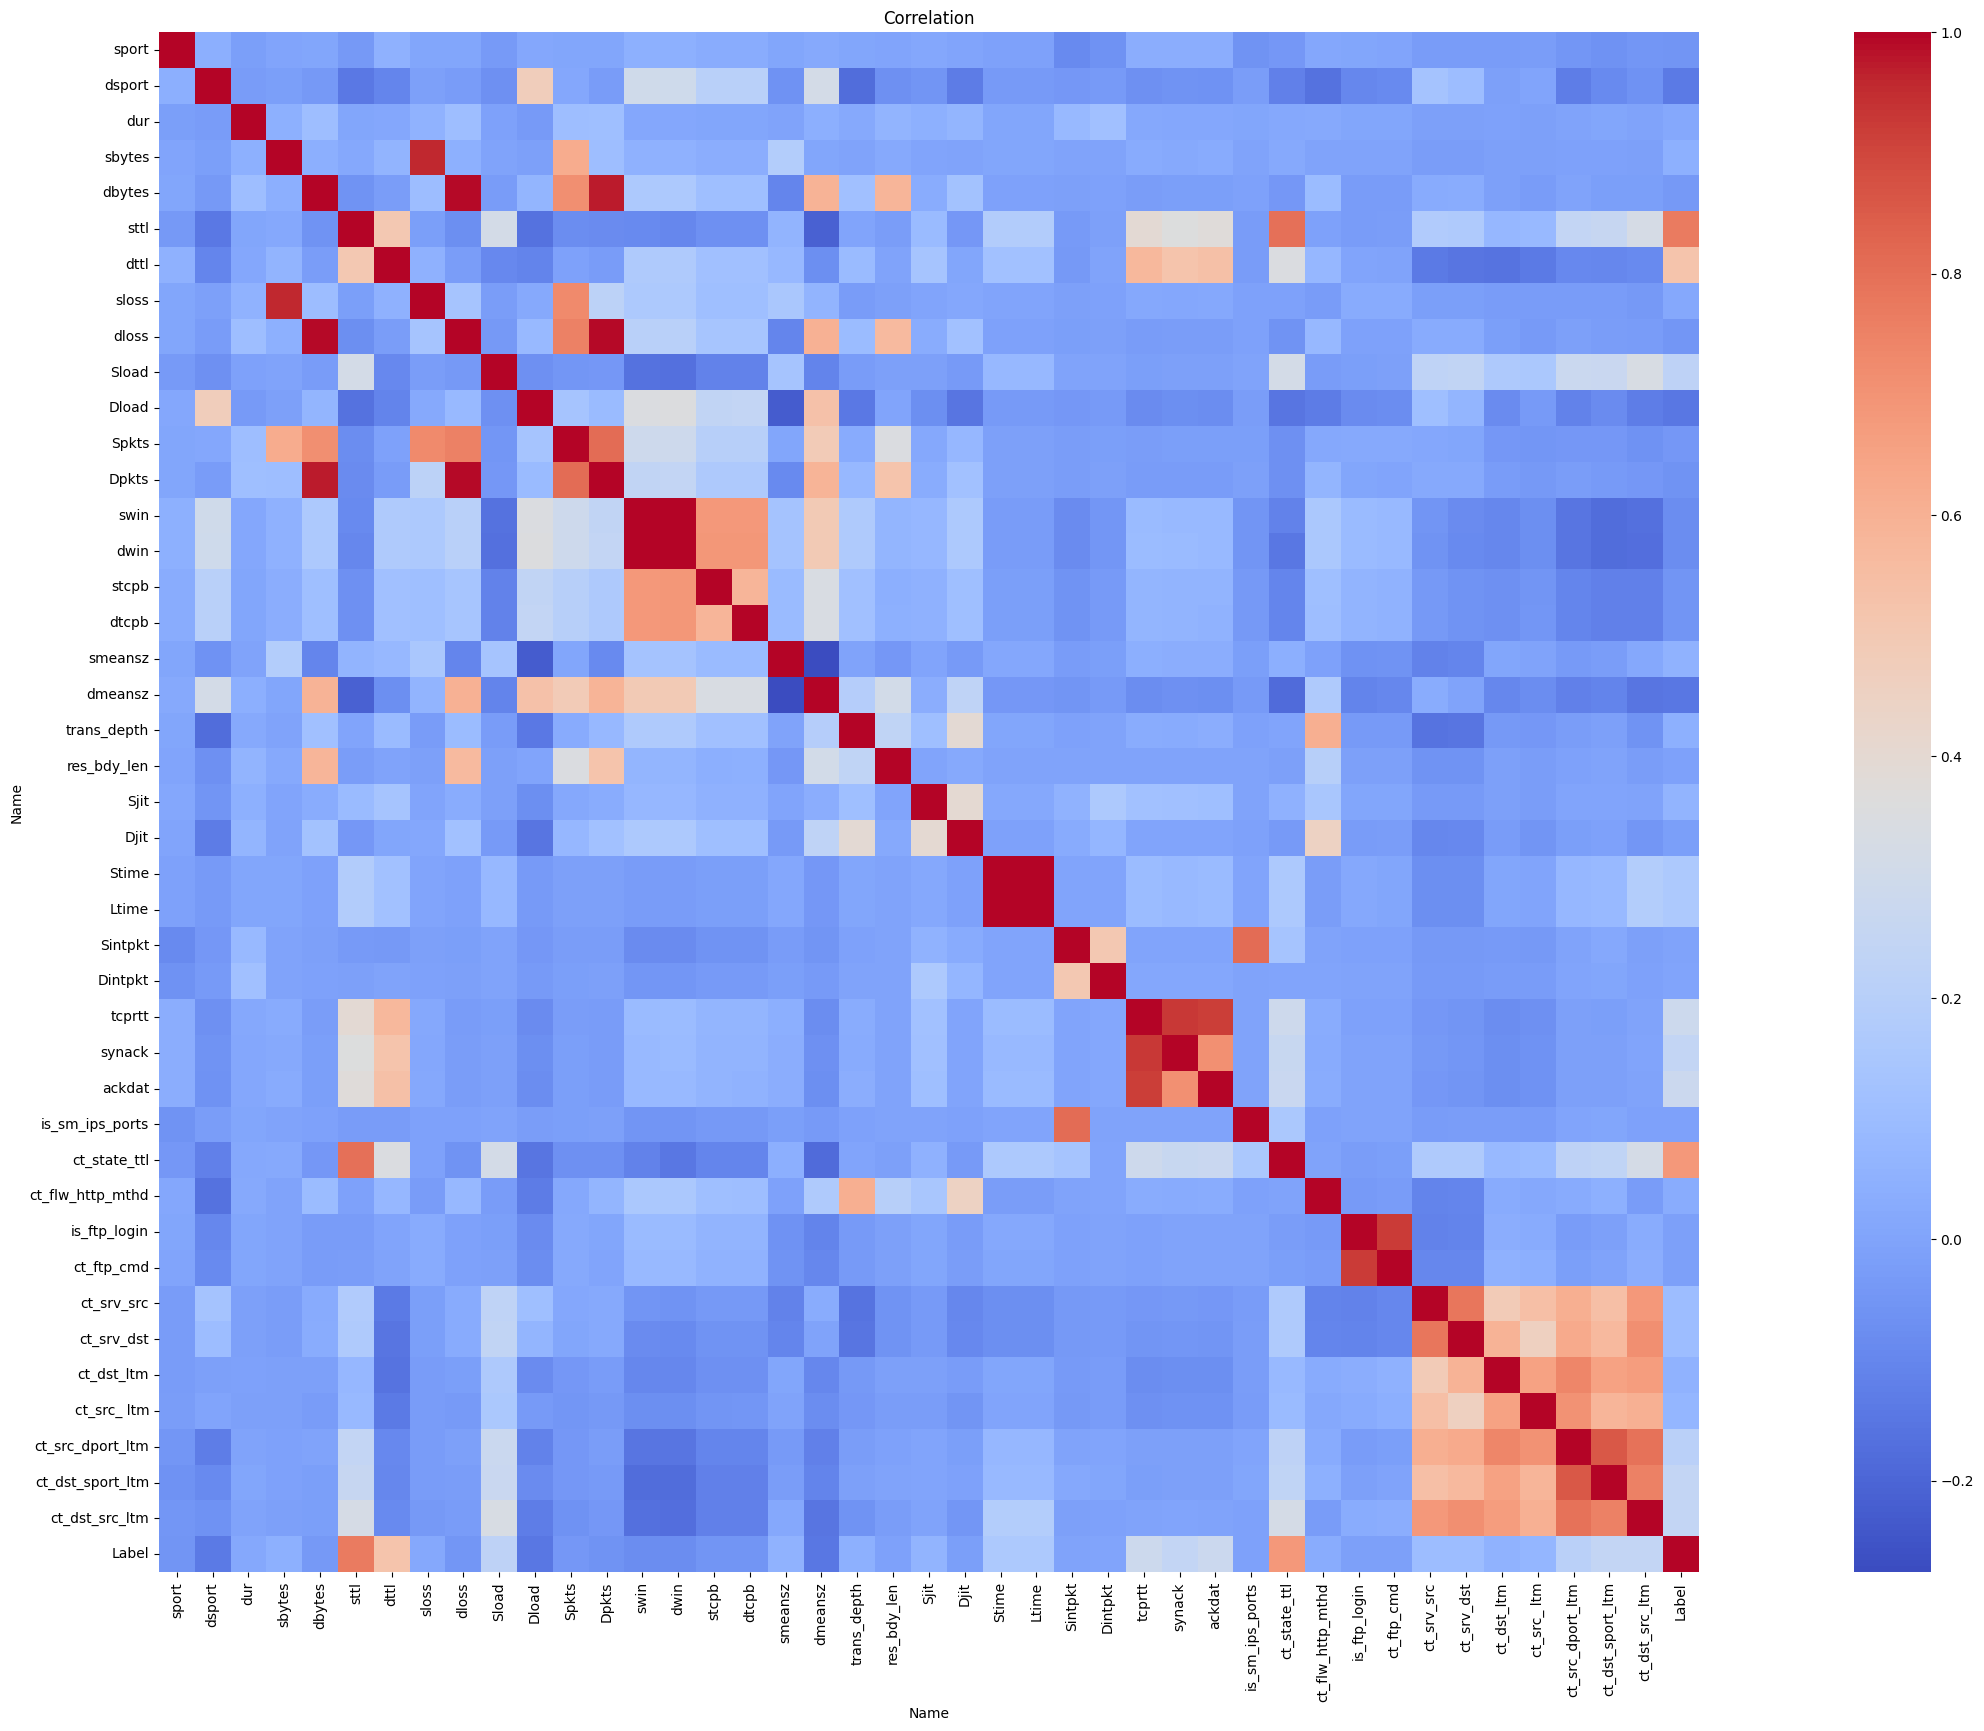

In [ ]:
plt.figure(figsize=(40,20))
plt.title("Correlation")
sns.heatmap(df[num_features].corr(), cmap='coolwarm', square=True)

**Les variables ‘ct_state_ttl’, ‘sttl’ et ‘dttl’ sont les plus corrélées avec la variable cible ‘Label’ (une forte corrélation positive)**

In [ ]:
corr_matrix = df[num_features].corr()
high_corr_mask = corr_matrix >= 0.75

highly_corr_features = []

for feature in high_corr_mask.columns:
    correlated_with = high_corr_mask.index[high_corr_mask[feature]].tolist()
    for correlated_feature in correlated_with:
        if feature != correlated_feature and (correlated_feature, feature) not in highly_corr_features:
            highly_corr_features.append((feature, correlated_feature))

In [ ]:
features_to_drop = set()
for feature1, feature2 in highly_corr_features:
    if feature1 not in features_to_drop and feature2 not in features_to_drop:
        features_to_drop.add(feature2)
features_to_drop

{'Dpkts',
 'Label',
 'Ltime',
 'ackdat',
 'ct_dst_sport_ltm',
 'ct_dst_src_ltm',
 'ct_ftp_cmd',
 'ct_srv_dst',
 'ct_state_ttl',
 'dloss',
 'dwin',
 'is_sm_ips_ports',
 'sloss',
 'synack'}

In [ ]:
features_to_drop.discard('Label')

In [ ]:
df = df.drop(columns=features_to_drop)

print("Remaining features after dropping highly correlated ones:")
print(df.columns)

Remaining features after dropping highly correlated ones:
Index(['srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'dur', 'sbytes',
       'dbytes', 'sttl', 'dttl', 'service', 'Sload', 'Dload', 'Spkts', 'swin',
       'stcpb', 'dtcpb', 'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len',
       'Sjit', 'Djit', 'Stime', 'Sintpkt', 'Dintpkt', 'tcprtt',
       'ct_flw_http_mthd', 'is_ftp_login', 'ct_srv_src', 'ct_dst_ltm',
       'ct_src_ ltm', 'ct_src_dport_ltm', 'attack_cat', 'Label'],
      dtype='object', name='Name')


## feature vs target

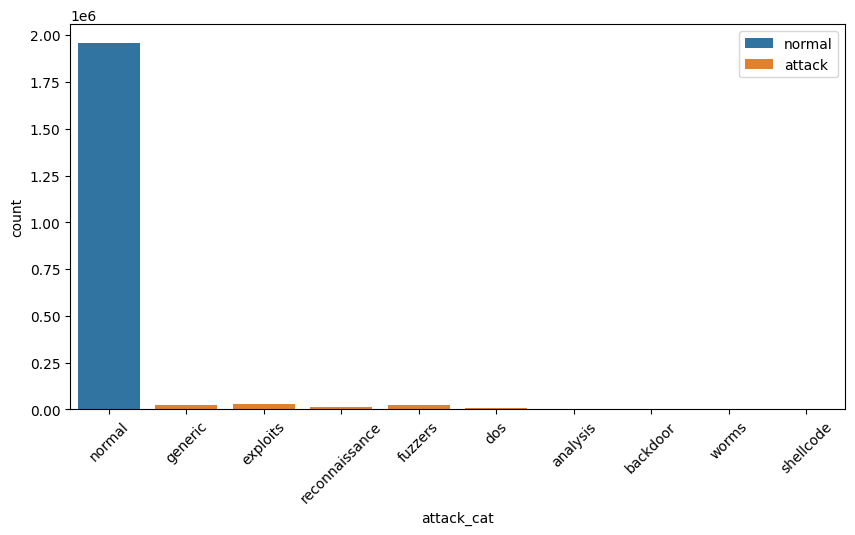

In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(x='attack_cat', hue='Label', data=df)
plt.legend(loc="upper right", labels=('normal', 'attack'))
plt.xticks(rotation=45)
plt.show()

In [ ]:
df['proto'].nunique()

135

In [ ]:
def reduce_column(s, to_keep):
    s = s.lower().strip()
    if s not in to_keep:
        return "others"
    else:
        return s

In [ ]:
df['proto'].value_counts().head(10)

,count
proto,
tcp,1448858
udp,588026
arp,6658
unas,4765
ospf,3964
icmp,498
sctp,444
any,138
gre,95


In [ ]:
df.groupby(['proto', 'Label'])['Label'].count().unstack().fillna(0)

Label,0,1
proto,,
3pc,0.0,46.0
a/n,0.0,46.0
aes-sp3-d,0.0,46.0
any,0.0,138.0
argus,0.0,46.0
aris,0.0,46.0
arp,6658.0,0.0
ax.25,0.0,46.0
bbn-rcc,0.0,46.0







*   **ICMP, IGMP, ARP, RTP et ESP sont parmi les protocoles les plus sécurisés, étant les moins vulnérables aux cyberattaques.**
*   **TCP, UDP et OSPF sont les protocoles les plus fréquemment observés dans notre dataset et enregistrent un faible nombre de cyberattaques par rapport aux actions normales.**
*   **D'autres protocoles, comme SCTP, VMTP et UNAS, sont les plus exposés aux cyberattaques.**





In [ ]:
to_keep = ['tcp', 'udp', 'unas', 'arp', 'ospf']
df['proto_reduced'] = df['proto'].apply(reduce_column, args=(to_keep,))

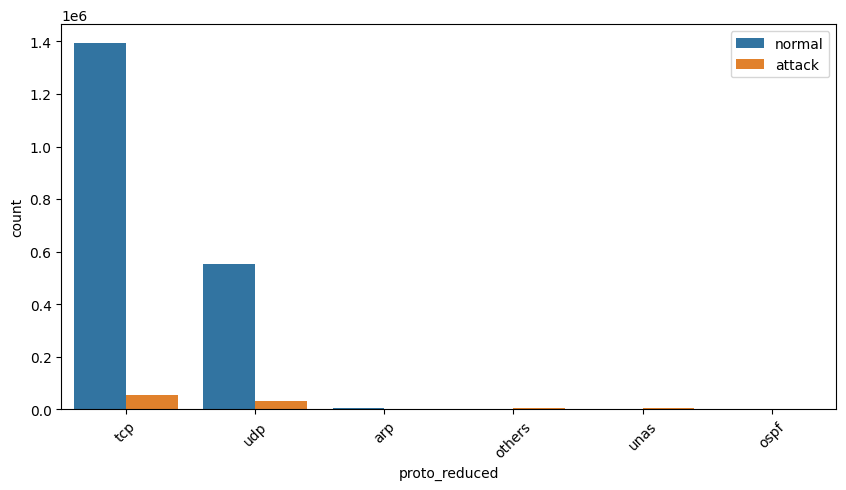

In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(x='proto_reduced', hue='Label', data=df)
plt.legend(loc="upper right", labels=('normal', 'attack'))
plt.xticks(rotation=45)
plt.show()

In [ ]:
df['service'].nunique()

13

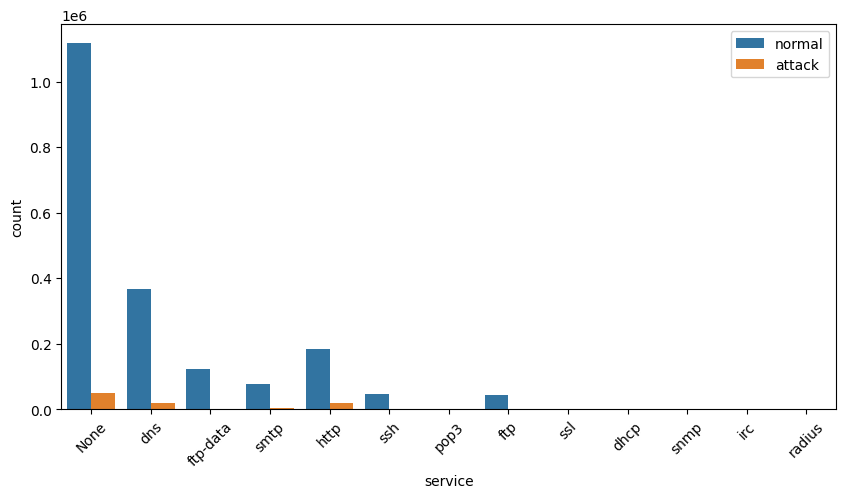

In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(x='service', hue='Label', data=df)
plt.legend(loc="upper right", labels=('normal', 'attack'))
plt.xticks(rotation=45)
plt.show()

**FTP et SSH figurent parmi les services les plus sécurisés, n'étant pas ciblés par les cyberattaques observées.**

In [ ]:
df['state'].value_counts()

,count
state,
FIN,1433507
CON,543296
INT,75340
REQ,6050
RST,525
ECO,313
CLO,160
URH,108
ACC,41


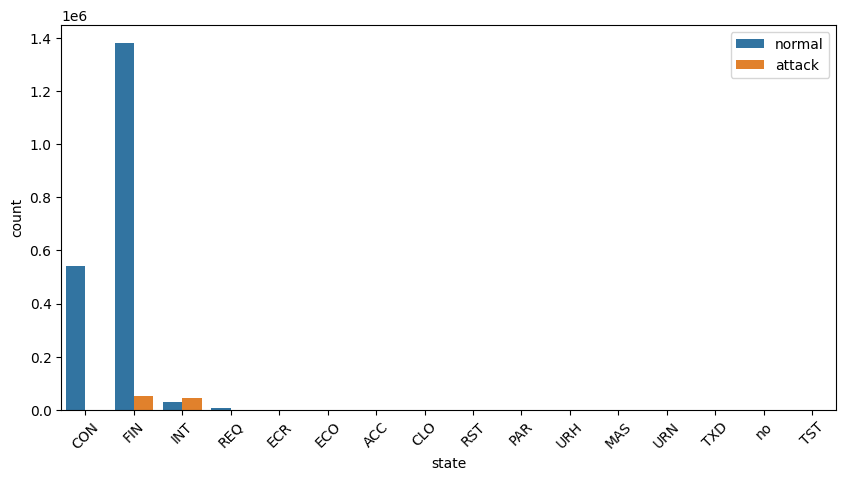

In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(x='state', hue='Label', data=df)
plt.legend(loc="upper right", labels=('normal', 'attack'))
plt.xticks(rotation=45)
plt.show()

In [ ]:
df.drop(columns=['proto_reduced'], inplace=True)

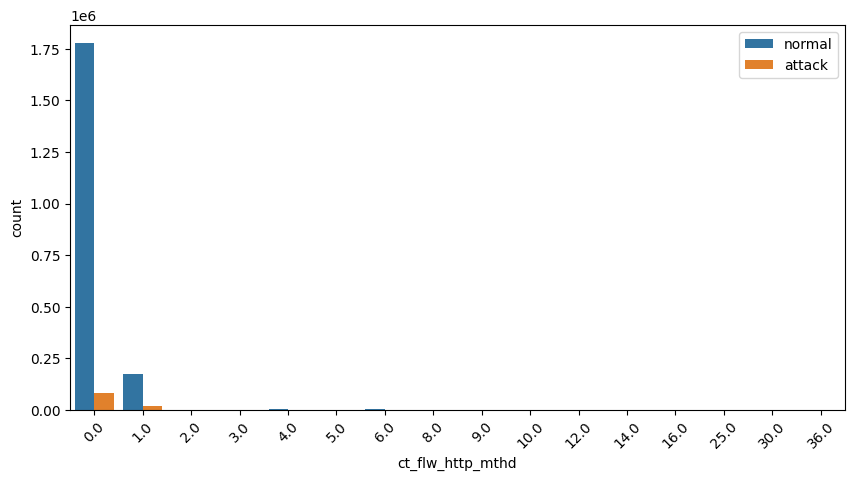

In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(x='ct_flw_http_mthd', hue='Label', data=df)
plt.legend(loc="upper right", labels=('normal', 'attack'))
plt.xticks(rotation=45)
plt.show()

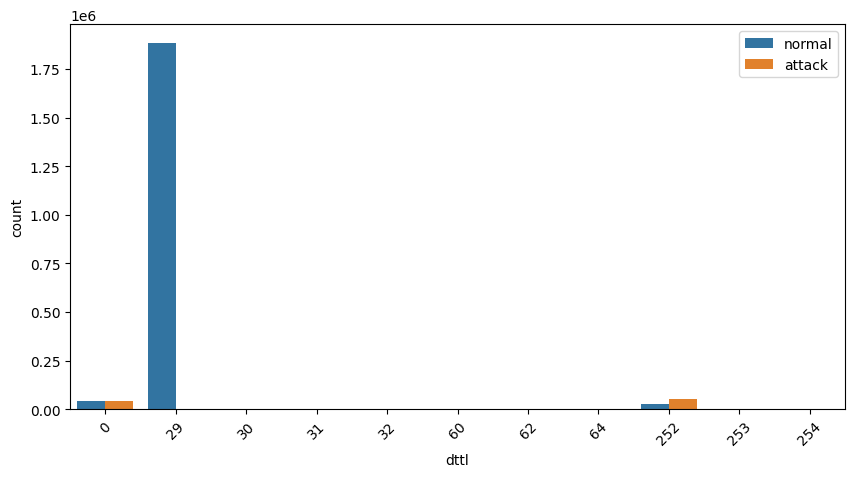

In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(x='dttl', hue='Label', data=df)
plt.legend(loc="upper right", labels=('normal', 'attack'))
plt.xticks(rotation=45)
plt.show()

**La valeur 29 est largement dominante, indiquant que la plupart des connexions utilisent un TTL standard.**

**Certaines valeurs atypiques (comme 0 et 252) contiennent proportionnellement plus d’attaques, ce qui pourrait suggérer un comportement malveillant tentant d’altérer la durée de vie des paquets.**

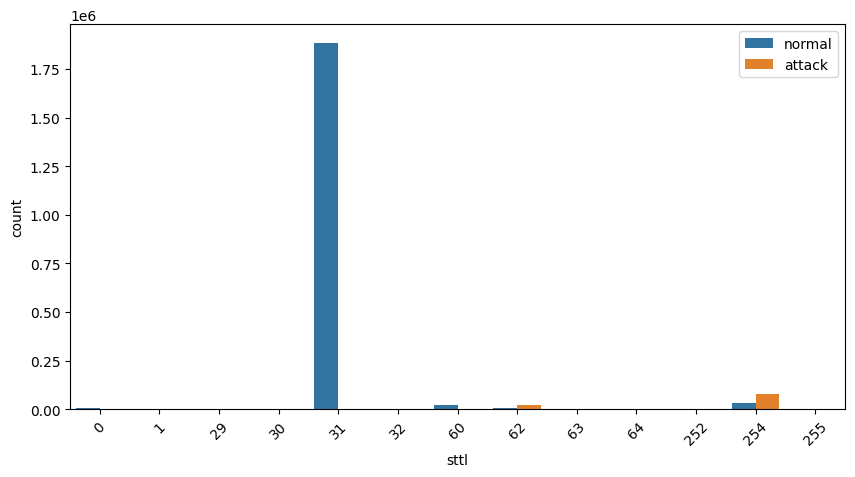

In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(x='sttl', hue='Label', data=df)
plt.legend(loc="upper right", labels=('normal', 'attack'))
plt.xticks(rotation=45)
plt.show()

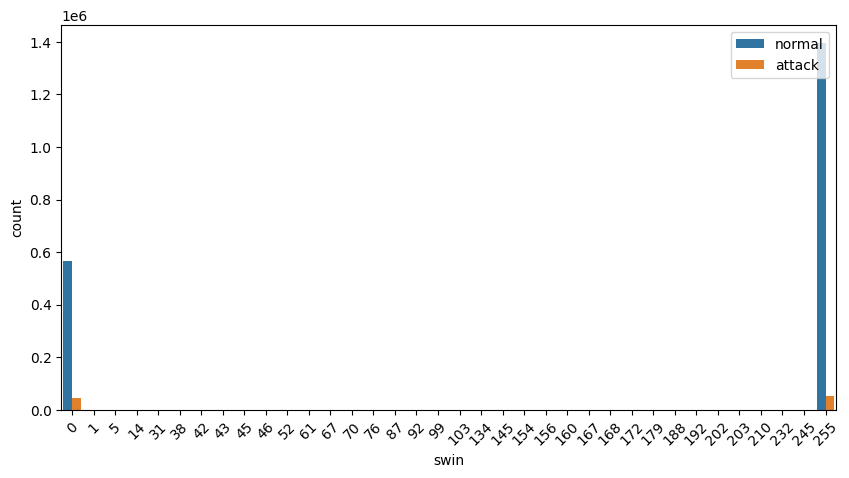

In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(x='swin', hue='Label', data=df)
plt.legend(loc="upper right", labels=('normal', 'attack'))
plt.xticks(rotation=45)
plt.show()

In [ ]:
df.groupby(['srcip', 'Label'])['Label'].count().unstack().fillna(0)

Label,0,1
srcip,,
10.40.170.2,1367.0,0.0
10.40.182.1,2607.0,0.0
10.40.182.3,1378.0,0.0
10.40.182.6,120.0,0.0
10.40.85.1,2647.0,0.0
10.40.85.10,758.0,0.0
10.40.85.30,1393.0,0.0
127.0.0.1,1.0,0.0
149.171.126.0,250.0,0.0


In [ ]:
df.groupby(['dstip', 'Label'])['Label'].count().unstack().fillna(0)

Label,0,1
dstip,,
10.40.170.2,1367.0,0.0
10.40.182.255,109.0,0.0
10.40.182.3,2497.0,0.0
10.40.182.6,11.0,0.0
10.40.198.10,260.0,0.0
10.40.85.1,1653.0,0.0
10.40.85.30,1130.0,0.0
127.0.0.1,1.0,0.0
149.171.126.0,191261.0,0.0


In [ ]:
df.drop(columns='attack_cat', inplace = True)

# data preprocessing

## features target split

In [ ]:
X = df.drop(columns=['Label'])
y = df['Label']

## standardizing numerical features

In [ ]:
num_feat = X.select_dtypes(include=['int64', 'float64','int32']).columns
num_feat

Index(['sport', 'dsport', 'dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'Sload',
       'Dload', 'Spkts', 'swin', 'stcpb', 'dtcpb', 'smeansz', 'dmeansz',
       'trans_depth', 'res_bdy_len', 'Sjit', 'Djit', 'Stime', 'Sintpkt',
       'Dintpkt', 'tcprtt', 'ct_flw_http_mthd', 'is_ftp_login', 'ct_srv_src',
       'ct_dst_ltm', 'ct_src_ ltm', 'ct_src_dport_ltm'],
      dtype='object', name='Name')

In [ ]:
standard_scaler = StandardScaler()

In [ ]:
X[num_feat] = standard_scaler.fit_transform(X[num_feat])

In [ ]:
X.head()

Name,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,dttl,service,Sload,Dload,Spkts,swin,stcpb,dtcpb,smeansz,dmeansz,trans_depth,res_bdy_len,Sjit,Djit,Stime,Sintpkt,Dintpkt,tcprtt,ct_flw_http_mthd,is_ftp_login,ct_srv_src,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm
0,175.45.176.3,1.308242,149.171.126.15,-0.527534,tcp,CON,-0.033111,-0.066177,-0.246325,0.364292,4.930977,None,-0.122817,-0.659121,-0.405667,0.649197,-0.522032,1.667556,0.206461,-0.845355,-0.260823,-0.098496,0.148607,-0.258874,0.978600,-0.041282,-0.052424,4.961222,-0.238532,-0.140172,0.885589,0.100523,0.231968,0.519281
1,59.166.0.8,0.294320,149.171.126.9,-0.341404,tcp,FIN,-0.030489,-0.057261,-0.237153,-0.249309,-0.171640,None,-0.122631,-0.650567,-0.281404,0.649197,-0.541163,0.978057,-0.206550,-0.704064,-0.260823,-0.098496,-0.019226,-0.248071,1.003347,-0.055776,-0.038006,-0.131564,-0.238532,-0.140172,1.656616,1.327106,2.176414,1.271730
2,59.166.0.0,0.545423,149.171.126.2,1.286887,udp,CON,-0.031678,-0.073419,-0.245042,-0.249309,-0.171640,None,-0.122985,-0.658038,-0.430520,-1.540389,-1.054712,-1.054654,0.024250,-0.748217,-0.260823,-0.098496,-0.112783,-0.220859,-1.019774,-0.031012,0.015814,-0.143382,-0.238532,-0.140172,0.692832,1.020461,0.509746,-0.233167
3,175.45.176.1,0.779421,149.171.126.14,-0.692384,udp,INT,-0.058948,-0.080210,-0.246831,4.164655,-0.835208,dns,0.564939,-0.659390,-0.455372,-1.540389,-1.054712,-1.054654,-0.443423,-0.971928,-0.260823,-0.098496,-0.121405,-0.258874,1.003220,-0.064163,-0.052425,-0.143382,-0.238532,-0.140172,5.318996,4.086919,3.565304,5.786420
4,59.166.0.5,1.508339,149.171.126.6,-0.692384,udp,CON,-0.058851,-0.079695,-0.245784,-0.249309,-0.171640,dns,-0.115780,-0.512109,-0.455372,-1.540389,-1.054712,-1.054654,-0.346244,-0.709951,-0.260823,-0.098496,-0.121405,-0.258874,0.995588,-0.064163,-0.052420,-0.143382,-0.238532,-0.140172,-0.656466,0.407169,-0.045810,-0.233167


## encoding categ features

In [ ]:
label_encoder = LabelEncoder()

In [ ]:
categ_feat = X.select_dtypes(include=['object']).columns
categ_feat

Index(['srcip', 'dstip', 'proto', 'state', 'service'], dtype='object', name='Name')

In [ ]:
X['srcip'] = label_encoder.fit_transform(X['srcip'])
X['dstip'] = label_encoder.fit_transform(X['dstip'])
X['proto'] = label_encoder.fit_transform(X['proto'])
X['state'] = label_encoder.fit_transform(X['state'])
X['service'] = label_encoder.fit_transform(X['service'])

In [ ]:
X.head().T

,0,1,2,3,4
Name,,,,,
srcip,31.000000,41.000000,33.000000,29.000000,38.000000
sport,1.308242,0.294320,0.545423,0.779421,1.508339
dstip,15.000000,27.000000,20.000000,14.000000,24.000000
dsport,-0.527534,-0.341404,1.286887,-0.692384,-0.692384
proto,114.000000,114.000000,120.000000,120.000000,120.000000
state,2.000000,5.000000,2.000000,6.000000,2.000000
dur,-0.033111,-0.030489,-0.031678,-0.058948,-0.058851
sbytes,-0.066177,-0.057261,-0.073419,-0.080210,-0.079695
dbytes,-0.246325,-0.237153,-0.245042,-0.246831,-0.245784


# Train Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1647533, 34), (411884, 34), (1647533,), (411884,))

# saving cleaned data

In [ ]:
#os.makedirs('cyber_attacks_cleaned_data', exist_ok=True)

#pickle.dump((X_train, y_train), open('final_train.pkl', 'wb'))
#pickle.dump((X_test, y_test), open('final_test.pkl', 'wb'))


# Loading cleaned data

In [ ]:
#X_train, y_train = pickle.load(open('final_train.pkl', 'rb'))
#X_test, y_test = pickle.load(open('final_test.pkl', 'rb'))

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1647533, 34), (411884, 34), (1647533,), (411884,))

# Modelling

In [ ]:
print(type(y_train))
print(type(y_test))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


## model building

## CNN

In [ ]:
cnn = Sequential()

# couche conv
cnn.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(34, 1),
                 kernel_regularizer=l2(0.01), kernel_initializer='glorot_uniform'))
cnn.add(BatchNormalization())
cnn.add(MaxPooling1D(pool_size=2))
cnn.add(Dropout(0.3))

# 2éme couche conv
cnn.add(Conv1D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)))
cnn.add(BatchNormalization())
cnn.add(MaxPooling1D(pool_size=2))
cnn.add(Dropout(0.3))

# 3éme couche conv
cnn.add(Conv1D(filters=128, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)))
cnn.add(BatchNormalization())
cnn.add(MaxPooling1D(pool_size=2))
cnn.add(Dropout(0.3))

# Aplatissement des features
cnn.add(Flatten())

# Couche dense
cnn.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.3))

# couche de sortie
cnn.add(Dense(1, activation='sigmoid'))

cnn.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 32, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 16, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 16, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 14, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 14, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 5, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 5, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 2, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 2, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,705 (190.25 KB)

 Trainable params: 48,129 (188.00 KB)

 Non-trainable params: 576 (2.25 KB)

In [ ]:
adam = Adam(learning_rate=0.001)
cnn.compile(optimizer=adam, loss=BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
history = cnn.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

Epoch 1/50
51486/51486 ━━━━━━━━━━━━━━━━━━━━ 233s 4ms/step - accuracy: 0.9699 - loss: 0.1798 - val_accuracy: 0.9813 - val_loss: 0.0535
Epoch 2/50
51486/51486 ━━━━━━━━━━━━━━━━━━━━ 234s 5ms/step - accuracy: 0.9786 - loss: 0.0646 - val_accuracy: 0.9826 - val_loss: 0.0529
Epoch 3/50
51486/51486 ━━━━━━━━━━━━━━━━━━━━ 228s 4ms/step - accuracy: 0.9782 - loss: 0.0631 - val_accuracy: 0.9809 - val_loss: 0.0510
Epoch 4/50
51486/51486 ━━━━━━━━━━━━━━━━━━━━ 228s 4ms/step - accuracy: 0.9786 - loss: 0.0609 - val_accuracy: 0.9808 - val_loss: 0.0521
Epoch 5/50
51486/51486 ━━━━━━━━━━━━━━━━━━━━ 229s 4ms/step - accuracy: 0.9783 - loss: 0.0613 - val_accuracy: 0.9805 - val_loss: 0.0507
Epoch 6/50
51486/51486 ━━━━━━━━━━━━━━━━━━━━ 229s 4ms/step - accuracy: 0.9781 - loss: 0.0610 - val_accuracy: 0.9802 - val_loss: 0.0555
Epoch 7/50
51486/51486 ━━━━━━━━━━━━━━━━━━━━ 227s 4ms/step - accuracy: 0.9780 - loss: 0.0609 - val_accuracy: 0.9809 - val_loss: 0.0525
Epoch 8/50
51486/51486 ━━━━━━━━━━━━━━━━━━━━ 227s 4ms/step - ac

In [ ]:
test_loss, test_accuracy = cnn.evaluate(X_test, y_test)
print("CNN Model")
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

12872/12872 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.9810 - loss: 0.0502
CNN Model
Test Loss: 0.05019428953528404
Test Accuracy: 0.9808975458145142


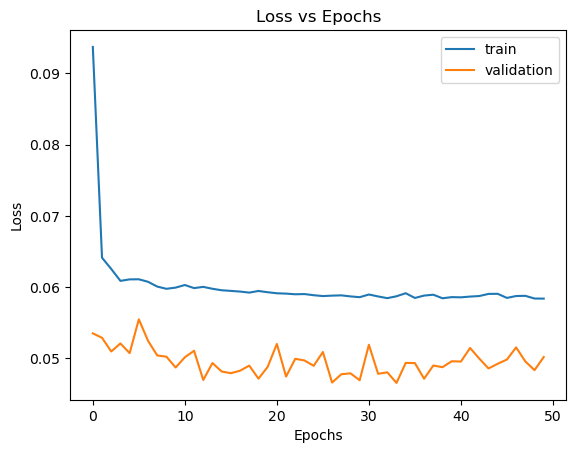

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'validation'])
plt.title('Loss vs Epochs')
plt.show()

Text(0.5, 1.0, 'Accuracy vs Epochs')

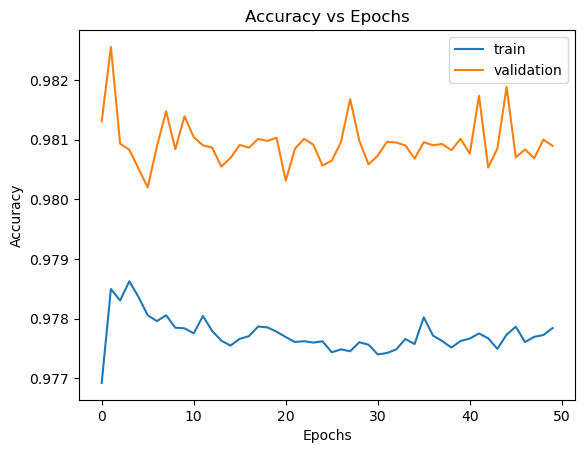

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'validation'])
plt.title('Accuracy vs Epochs')

In [ ]:
y_pred_cnn = cnn.predict(X_test)

12872/12872 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step


In [ ]:
y_pred_classes_cnn = (y_pred_cnn >= 0.5).astype(int)
y_pred_classes_cnn.shape

(411884, 1)

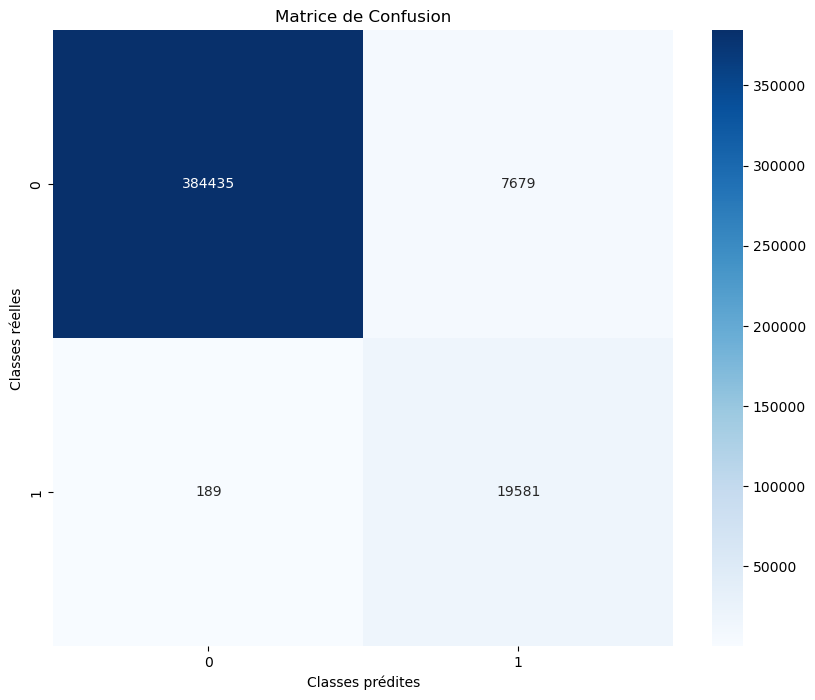

In [ ]:
cm = confusion_matrix(y_test, y_pred_classes_cnn)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(2), yticklabels=np.arange(2))
plt.xlabel('Classes prédites')
plt.ylabel('Classes réelles')
plt.title('Matrice de Confusion')
plt.show()

In [ ]:
accuracy = accuracy_score(y_test, y_pred_classes_cnn)
recall = recall_score(y_test, y_pred_classes_cnn, average='weighted')
precision = precision_score(y_test, y_pred_classes_cnn, average='weighted')
f1s = f1_score(y_test, y_pred_classes_cnn, average='weighted')

print("CNN Model")
print("Accuracy: "+ "{:.2%}".format(accuracy))
print("Recall: "+ "{:.2%}".format(recall))
print("Precision: "+ "{:.2%}".format(precision))
print("F1-Score: "+ "{:.2%}".format(f1s))

CNN Model
Accuracy: 98.09%
Recall: 98.09%
Precision: 98.60%
F1-Score: 98.23%


In [ ]:
model_performance = pd.DataFrame(columns=['Accuracy','Recall','Precision','F1-Score'])

In [ ]:
model_performance.loc['CNN'] = [accuracy, recall, precision, f1s]

In [ ]:
model_performance

,Accuracy,Recall,Precision,F1-Score
CNN,0.980898,0.980898,0.986011,0.982327


**Le modèle affiche une bonne performance avec une faible erreur de test , indiquant une bonne généralisation aux données de test, et une précision élevée de 98 %, montrant qu’il classe correctement la majorité des échantillons.**

#comparing with Logistic regression

---



##LogisticRegression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [ ]:
y_pred_logreg = logreg.predict(X_test)

accuracy1 = accuracy_score(y_test, y_pred_logreg)
recall1 = recall_score(y_test, y_pred_logreg)
precision1 = precision_score(y_test, y_pred_logreg)
f11 = f1_score(y_test, y_pred_logreg)

In [ ]:
print("Logitic Regression Model")
print("Accuracy: "+ "{:.2%}".format(accuracy1))
print("Recall: "+ "{:.2%}".format(recall1))
print("Precision: "+ "{:.2%}".format(precision1))
print("F1-Score: "+ "{:.2%}".format(f11))

Logitic Regression Model
Accuracy: 98.41%
Recall: 88.65%
Precision: 80.27%
F1-Score: 84.25%


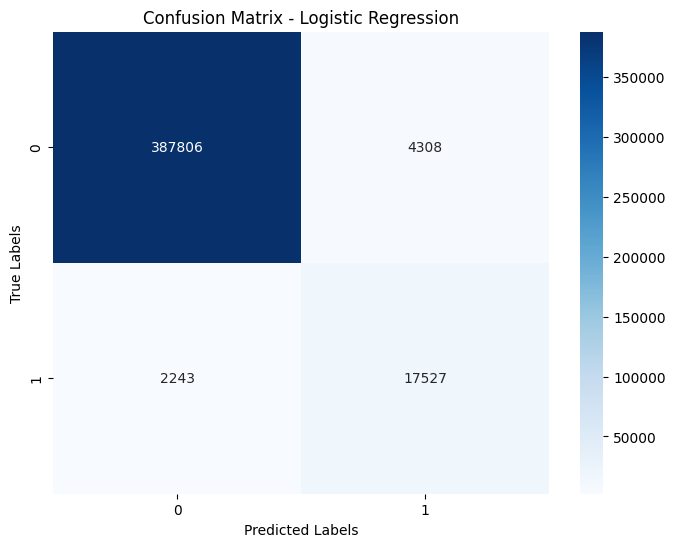

In [ ]:
cm = confusion_matrix(y_test, y_pred_logreg)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

In [ ]:
logreg_performance = pd.DataFrame(columns=['Accuracy','Recall','Precision','F1-Score'])
logreg_performance.loc['Logistic Regression'] = [accuracy1, recall1, precision1, f11]
logreg_performance

,Accuracy,Recall,Precision,F1-Score
Logistic Regression,0.984095,0.886545,0.802702,0.842543


# resampling(under_sampling and smote)

In [ ]:
desired_count = 15000
oversample_strategy = {i: desired_count for i in range(len(y.value_counts())) if y.value_counts()[i] < desired_count}
undersample_strategy = {i: desired_count for i in range(len(y.value_counts())) if y.value_counts()[i] > desired_count}

smote = SMOTE(sampling_strategy=oversample_strategy)
undersample = RandomUnderSampler(sampling_strategy=undersample_strategy)
pipeline = Pipeline(steps=[('smote', smote), ('undersample', undersample)])

print("Before resampling:", y.value_counts())
print()

X_resampled, y_resampled = pipeline.fit_resample(X, y)
print("After resampling:", y_resampled.value_counts())

Before resampling: 0    100000
1     10000
Name: count, dtype: int64



ValueError: Found input variables with inconsistent numbers of samples: [2059417, 110000]

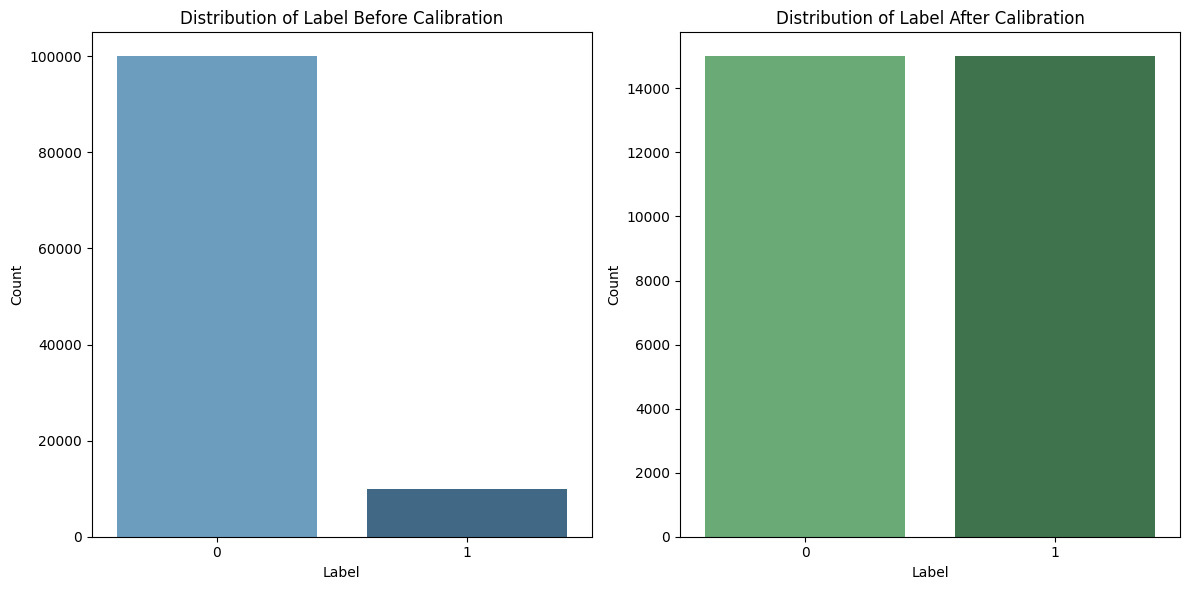

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.countplot(x=y, palette="Blues_d") # Added color palette
plt.title('Distribution of Label Before Calibration')
plt.xlabel('Label')
plt.ylabel('Count')


plt.subplot(1, 2, 2)
sns.countplot(x=y_resampled, palette="Greens_d") # Added color palette
plt.title('Distribution of Label After Calibration')
plt.xlabel('Label')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [ ]:
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
X_train_resampled.shape, X_test_resampled.shape, y_train_resampled.shape, y_test_resampled.shape

((24000, 34), (6000, 34), (24000,), (6000,))

## cnn after data resampling

In [ ]:
# Entraînement du modèle
history2 = cnn.fit(X_train_resampled, y_train_resampled, epochs=50,
                    validation_data=(X_test_resampled, y_test_resampled))

Epoch 1/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 106s 142ms/step - accuracy: 0.8777 - loss: 0.3096 - val_accuracy: 0.9875 - val_loss: 0.0748
Epoch 2/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 105s 140ms/step - accuracy: 0.9834 - loss: 0.0958 - val_accuracy: 0.9878 - val_loss: 0.0747
Epoch 3/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 106s 142ms/step - accuracy: 0.9862 - loss: 0.0838 - val_accuracy: 0.9880 - val_loss: 0.0733
Epoch 4/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 104s 139ms/step - accuracy: 0.9849 - loss: 0.0917 - val_accuracy: 0.9882 - val_loss: 0.0728
Epoch 5/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 105s 140ms/step - accuracy: 0.9853 - loss: 0.0872 - val_accuracy: 0.9873 - val_loss: 0.0731
Epoch 6/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 109s 145ms/step - accuracy: 0.9844 - loss: 0.0947 - val_accuracy: 0.9882 - val_loss: 0.0716
Epoch 7/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 105s 140ms/step - accuracy: 0.9836 - loss: 0.0961 - val_accuracy: 0.9870 - val_loss: 0.0775
Epoch 8/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 104s 139ms/step - accuracy: 0.9843 -

In [ ]:
y_pred_resampled = cnn.predict(X_test_resampled)

188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step


In [ ]:
y_pred_resampled_classes_cnn = (y_pred_resampled >= 0.5).astype(int)

In [ ]:
y_test_resampled.shape, y_pred_resampled_classes_cnn.shape

((6000,), (6000, 1))

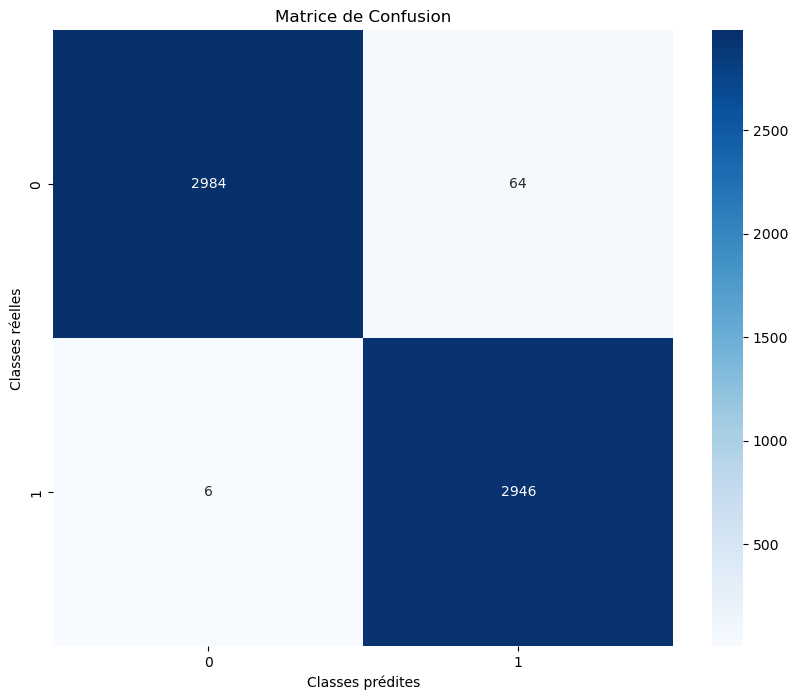

In [ ]:
cm = confusion_matrix(y_test_resampled, y_pred_resampled_classes_cnn)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(2), yticklabels=np.arange(2))
plt.xlabel('Classes prédites')
plt.ylabel('Classes réelles')
plt.title('Matrice de Confusion')
plt.show()

In [ ]:
accuracy = accuracy_score(y_test_resampled, y_pred_resampled_classes_cnn)
recall = recall_score(y_test_resampled, y_pred_resampled_classes_cnn, average='weighted')
precision = precision_score(y_test_resampled, y_pred_resampled_classes_cnn, average='weighted')
f1s = f1_score(y_test_resampled, y_pred_resampled_classes_cnn, average='weighted')

print("CNN after data resampling")
print("Accuracy: "+ "{:.2%}".format(accuracy))
print("Recall: "+ "{:.2%}".format(recall))
print("Precision: "+ "{:.2%}".format(precision))
print("F1-Score: "+ "{:.2%}".format(f1s))

CNN after data resampling
Accuracy: 98.83%
Recall: 98.83%
Precision: 98.85%
F1-Score: 98.83%


In [ ]:
model_performance.loc['CNN_with_resampled_data'] = [accuracy, recall, precision, f1s]

In [ ]:
model_performance.style.background_gradient(cmap='Blues').format({'Accuracy': '{:.2%}',
                                                                     'Precision': '{:.2%}',
                                                                     'Recall': '{:.2%}',
                                                                     'F1-Score': '{:.2%}'
                                                                     })

,Accuracy,Recall,Precision,F1-Score
CNN,98.09%,98.09%,98.60%,98.23%
CNN_with_resampled_data,98.83%,98.83%,98.85%,98.83%


##Logistic regression after resampling

In [ ]:
logreg = LogisticRegression()
logreg.fit(X_train_resampled, y_train_resampled)

LogisticRegression()

In [ ]:
y_pred_logreg = logreg.predict(X_test_resampled)

In [ ]:
accuracy_r = accuracy_score(y_test_resampled, y_pred_logreg)
recall_r = recall_score(y_test_resampled, y_pred_logreg)
precision_r = precision_score(y_test_resampled, y_pred_logreg)
f1_r = f1_score(y_test_resampled, y_pred_logreg)

print("Logistic Regression Model after resampling")
print("Accuracy: "+ "{:.2%}".format(accuracy_r))
print("Recall: "+ "{:.2%}".format(recall_r))
print("Precision: "+ "{:.2%}".format(precision_r))
print("F1-Score: "+ "{:.2%}".format(f1_r))

Logistic Regression Model after resampling
Accuracy: 98.87%
Recall: 99.59%
Precision: 98.13%
F1-Score: 98.86%


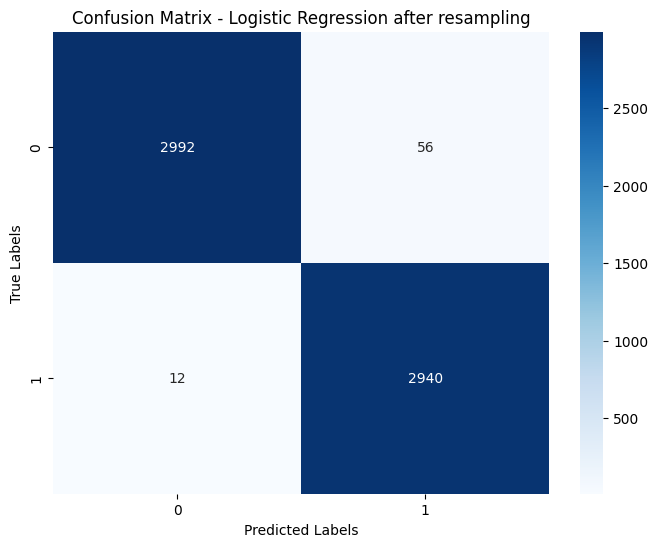

In [ ]:
cm = confusion_matrix(y_test_resampled, y_pred_logreg)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y_test_resampled), yticklabels=np.unique(y_test_resampled))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - Logistic Regression after resampling")
plt.show()

In [ ]:
logreg_performance.loc['Logistic Regression_with_resampled_data'] = [accuracy_r, recall_r, precision_r, f1_r]
logreg_performance.style.background_gradient(cmap='Blues').format({'Accuracy': '{:.2%}',
                                                                     'Precision': '{:.2%}',
                                                                     'Recall': '{:.2%}',
                                                                     'F1-Score': '{:.2%}'
                                                                     })

,Accuracy,Recall,Precision,F1-Score
Logistic Regression,98.41%,88.65%,80.27%,84.25%
Logistic Regression_with_resampled_data,98.87%,99.59%,98.13%,98.86%


In [ ]:
logreg_performance

# saving the model

In [ ]:
with open('model_CNN.pkl', 'wb') as file:
   pickle.dump(cnn, file)